In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as PCA_sklearn
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import seaborn as sns



In [4]:
df = pd.read_excel('Online Retail.xlsx')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [11]:
df['Description'] = df['Description'].fillna('Unknown')


In [12]:
df = df.dropna(subset=['CustomerID'])


In [13]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [15]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
df_cleaned = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [18]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


# **PART 2**

Создание признаков (15 баллов)


In [20]:
latest_date = df_cleaned['InvoiceDate'].max()

# Group by CustomerID
customer_features = df_cleaned.groupby('CustomerID').agg(
    Frequency=('InvoiceNo', 'nunique'),  # Count unique invoices
    MonetaryValue=('Quantity', lambda x: (x * df_cleaned.loc[x.index, 'UnitPrice']).sum()),  # Total amount spnt
    Recency=('InvoiceDate', lambda x: (latest_date - x.max()).days),  # last purchase date
    TotalQuantity=('Quantity', 'sum'),  # Total quantity purchased
    UniqueProducts=('StockCode', 'nunique'),  # Unique items purchased
    AverageOrderValue=('InvoiceNo', lambda x: (
        (df_cleaned.loc[x.index, 'Quantity'] * df_cleaned.loc[x.index, 'UnitPrice']).sum() / x.nunique()
    )),
).reset_index()

In [21]:
print("Customer-level features:")
print(customer_features.head())

Customer-level features:
   CustomerID  Frequency  MonetaryValue  Recency  TotalQuantity  \
0     12346.0          1       77183.60      325          74215   
1     12347.0          7        4310.00        1           2458   
2     12348.0          4        1797.24       74           2341   
3     12349.0          1        1757.55       18            631   
4     12350.0          1         334.40      309            197   

   UniqueProducts  AverageOrderValue  
0               1       77183.600000  
1             103         615.714286  
2              22         449.310000  
3              73        1757.550000  
4              17         334.400000  


# **PART 3**

Снижение размерности и PCA анализ

In [23]:
features = ['Frequency', 'MonetaryValue', 'Recency', 'TotalQuantity', 'UniqueProducts', 'AverageOrderValue']
X = customer_features[features]

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
cov_matrix = np.cov(X_scaled.T)

In [26]:
eigvals, eigvecs = np.linalg.eig(cov_matrix)


In [27]:
eigvals_sorted_idx = np.argsort(eigvals)[::-1]  # Indices for sorting eigenvalues in descending order
eigvals_sorted = eigvals[eigvals_sorted_idx]
eigvecs_sorted = eigvecs[:, eigvals_sorted_idx]

In [28]:
X_pca = X_scaled.dot(eigvecs_sorted)


In [29]:
principal_components = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])


In [30]:
print("Eigenvalues (explained variance):")
print(eigvals_sorted)

Eigenvalues (explained variance):
[2.95744399 1.31448295 0.84366773 0.54580593 0.26350468 0.07647816]


In [31]:
print("Explained variance ratio (percentage of total variance explained by each component):")
explained_variance_ratio = eigvals_sorted / eigvals_sorted.sum()
print(explained_variance_ratio)

Explained variance ratio (percentage of total variance explained by each component):
[0.49279371 0.21902999 0.14057888 0.09094668 0.04390732 0.01274342]


In [32]:
print("Principal components:")
print(principal_components.head())

Principal components:
         PC1        PC2        PC3        PC4       PC5       PC6
0  20.394339 -33.452828  16.195468  16.739305  4.379481 -3.868796
1   0.817778   0.535984   0.600235  -0.025265 -0.051089  0.006212
2  -0.064734  -0.186018   0.212252  -0.372806  0.192566 -0.198180
3   0.088313  -0.156906   1.056605   0.323700 -0.221501  0.073842
4  -1.032890  -1.226616  -1.608797   0.315090 -0.003776  0.003211


# **PART 4**
Сравнение PCA SKLearn

In [34]:
pca_sklearn = PCA_sklearn(n_components=X_scaled.shape[1])  # Set the number of components to the number of features
pca_sklearn.fit(X_scaled)

PCA(n_components=6)

In [35]:
explained_variance_ratio_sklearn = pca_sklearn.explained_variance_ratio_
principal_components_sklearn = pca_sklearn.components_


In [36]:
print("Explained Variance Ratio (Manual PCA):")
print(explained_variance_ratio)
print("\nExplained Variance Ratio (sklearn PCA):")
print(explained_variance_ratio_sklearn)

Explained Variance Ratio (Manual PCA):
[0.49279371 0.21902999 0.14057888 0.09094668 0.04390732 0.01274342]

Explained Variance Ratio (sklearn PCA):
[0.49279371 0.21902999 0.14057888 0.09094668 0.04390732 0.01274342]


In [37]:
eigenvalues_sklearn = pca_sklearn.explained_variance_

print("\nEigenvalues (Manual PCA):")
print(eigvals_sorted)
print("\nEigenvalues (sklearn PCA):")
print(eigenvalues_sklearn)


Eigenvalues (Manual PCA):
[2.95744399 1.31448295 0.84366773 0.54580593 0.26350468 0.07647816]

Eigenvalues (sklearn PCA):
[2.95744399 1.31448295 0.84366773 0.54580593 0.26350468 0.07647816]


In [38]:
print("\nPrincipal Components (Manual PCA):")
print(eigvecs_sorted)
print("\nPrincipal Components (sklearn PCA):")
print(principal_components_sklearn)


Principal Components (Manual PCA):
[[ 0.46471525  0.32572811 -0.26307437  0.10846629  0.77250296 -0.01438958]
 [ 0.51327897 -0.26659517 -0.07971064 -0.37855251 -0.15730289  0.7007651 ]
 [-0.18939735 -0.46100353 -0.82876671  0.25424585 -0.00953421  0.00427602]
 [ 0.5183611  -0.26339725 -0.07587687 -0.33404357 -0.19297352 -0.71227977]
 [ 0.40777133  0.41657415 -0.14024932  0.58074727 -0.54961977  0.03419605]
 [ 0.22301883 -0.60612856  0.46060467  0.57570792  0.19769524  0.01382345]]

Principal Components (sklearn PCA):
[[ 0.46471525  0.51327897 -0.18939735  0.5183611   0.40777133  0.22301883]
 [-0.32572811  0.26659517  0.46100353  0.26339725 -0.41657415  0.60612856]
 [ 0.26307437  0.07971064  0.82876671  0.07587687  0.14024932 -0.46060467]
 [ 0.10846629 -0.37855251  0.25424585 -0.33404357  0.58074727  0.57570792]
 [ 0.77250296 -0.15730289 -0.00953421 -0.19297352 -0.54961977  0.19769524]
 [ 0.01438958 -0.7007651  -0.00427602  0.71227977 -0.03419605 -0.01382345]]


# **PART 5**
Анализ оптимального количества кластеров

In [40]:
cluster_range = range(2, 11)
silhouette_scores = []
calinski_scores = []


In [41]:
for k in cluster_range:
    # KMeans cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)


    labels = kmeans.labels_

    # Calculate Silhouette Score
    silhouette = silhouette_score(X, labels)
    silhouette_scores.append(silhouette)

    # Calculate Calinski-Harabasz Score
    calinski = calinski_harabasz_score(X, labels)
    calinski_scores.append(calinski)

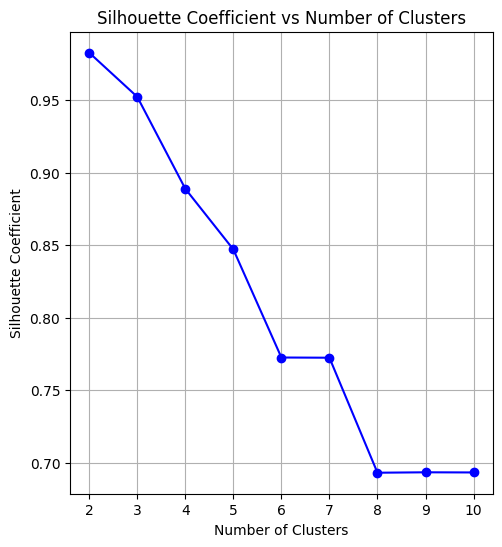

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Coefficient vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

#The Silhouette Score measures
#how well-separated the clusters are.
#It evaluates how similar each point is to its own cluster compared to other clusters
#that's why it decreases



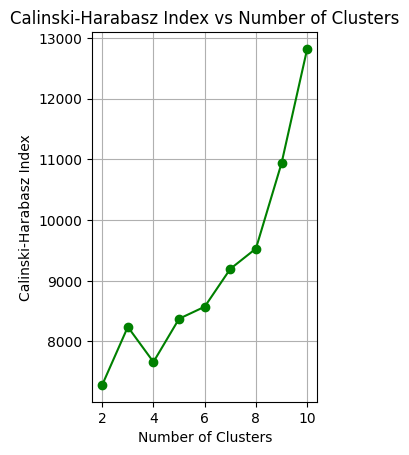

In [45]:
plt.subplot(1, 2, 2)
plt.plot(cluster_range, calinski_scores, marker='o', color='g')
plt.title('Calinski-Harabasz Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.grid(True)

#As the number of clusters increases,
#the clusters tend to become more compact and distinct from each other,
#leading to an increase in the Calinski-Harabasz index.

# **PART 6**
Сравнение алгоритмов кластеризации

In [49]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)


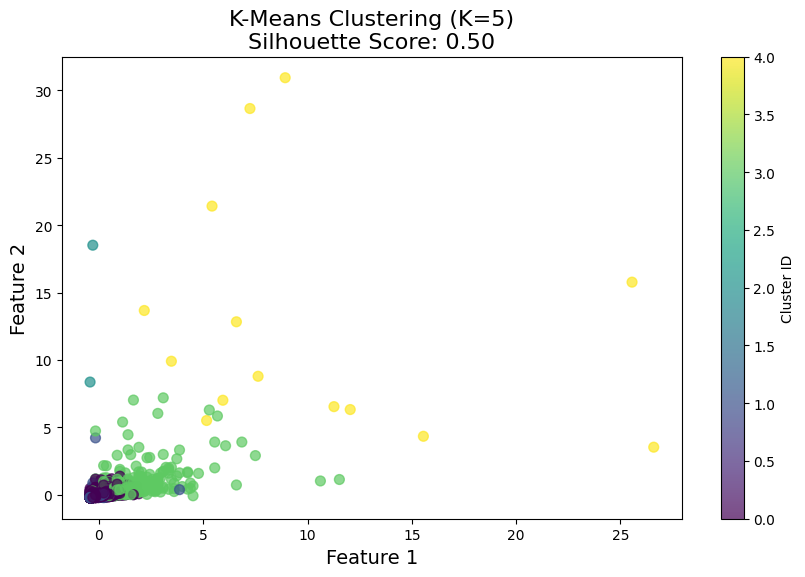

In [58]:

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)


plt.colorbar(scatter, label='Cluster ID')


plt.title(f'K-Means Clustering (K={optimal_k})\nSilhouette Score: {kmeans_silhouette:.2f}', fontsize=16)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)

plt.show()

In [52]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

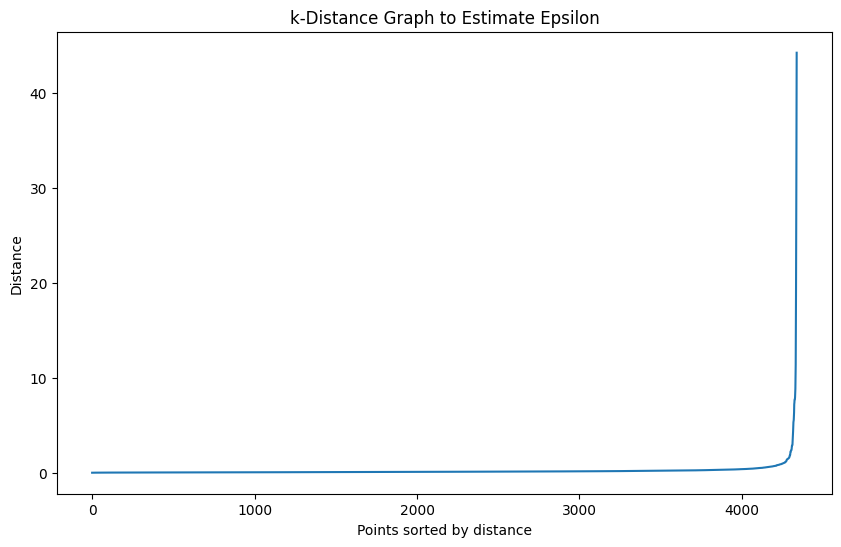

In [53]:
# Sort the distances for each point to visualize the k-distance graph
distances = np.sort(distances[:, -1], axis=0)

# Plot the k-distance graph to estimate eps
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('k-Distance Graph to Estimate Epsilon')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance')
plt.show()

In [59]:
eps_value = 0.5

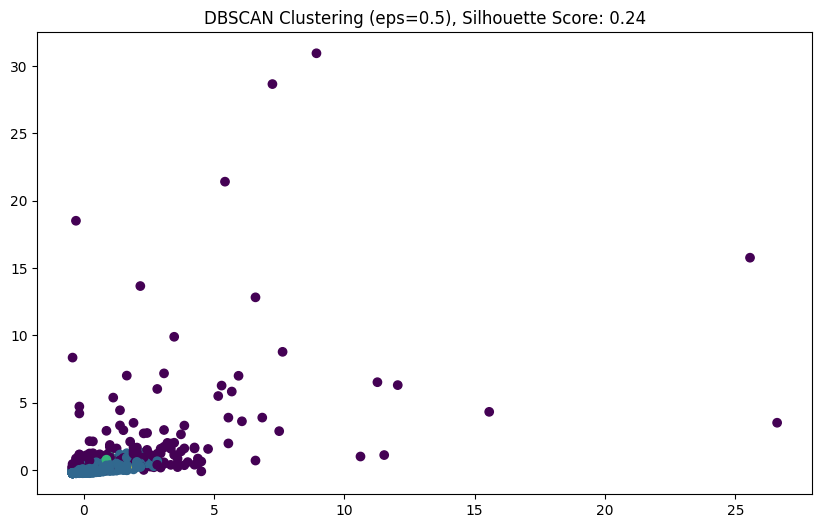

In [60]:
dbscan = DBSCAN(eps=eps_value, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_scaled)
dbscan_silhouette = silhouette_score(X_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels, cmap='viridis')
plt.title(f'DBSCAN Clustering (eps={eps_value}), Silhouette Score: {dbscan_silhouette:.2f}')
plt.show()

In [67]:
def apply_clustering(X, model):
    model.fit(X)
    if isinstance(model, KMeans):
        return model.labels_, model.inertia_  # KMeans returns labels and inertia
    elif isinstance(model, DBSCAN):
        return model.labels_, None  # DBSCAN only returns labels (no inertia)

kmeans_job = delayed(apply_clustering)(X_scaled, KMeans(n_clusters=optimal_k, random_state=42))
dbscan_job = delayed(apply_clustering)(X_scaled, DBSCAN(eps=eps_value, min_samples=4))

results = Parallel(n_jobs=-1)([kmeans_job, dbscan_job])

kmeans_labels, kmeans_inertia = results[0]
dbscan_labels, _ = results[1]

print(kmeans_labels)
print(dbscan_labels)


[2 0 0 ... 0 3 0]
[-1  0  0 ...  0  0  0]


# **PART 7**
Профилирование кластеров

In [70]:
# Add the cluster labels to the dataframe
df_clustered = pd.DataFrame(X_scaled, columns=[f"Feature_{i}" for i in range(X_scaled.shape[1])])
df_clustered['Cluster'] = kmeans_labels

# Calculate the mean for each feature within each cluster
cluster_profiles = df_clustered.groupby('Cluster').mean()

# Display the cluster profiles
print("Cluster Profiles (Mean values for each feature):")
print(cluster_profiles)



Cluster Profiles (Mean values for each feature):
         Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
Cluster                                                                  
0        -0.119762  -0.098724  -0.463515  -0.095403  -0.135042  -0.031102
1        -0.351422  -0.172057   1.572320  -0.184733  -0.438565  -0.054593
2        -0.360137  13.436935   0.709617  15.145122  -0.697086  44.697088
3         1.338307   0.612795  -0.760415   0.618349   1.745736   0.102098
4        10.256092  12.514295  -0.848913  12.378385   7.614232   0.945847


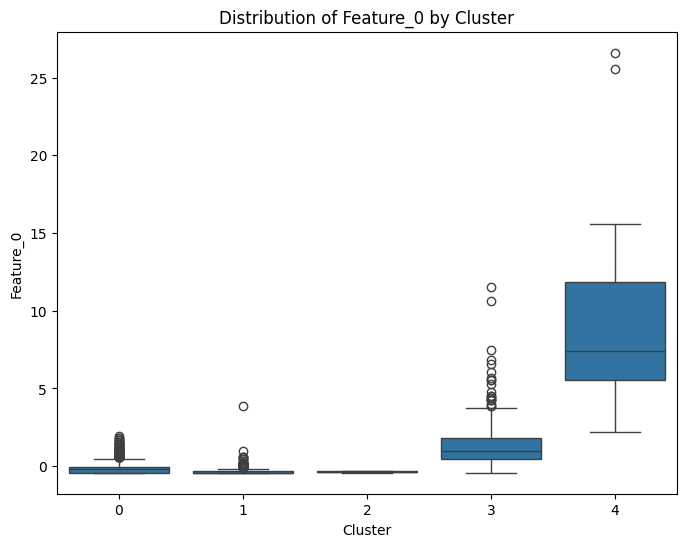

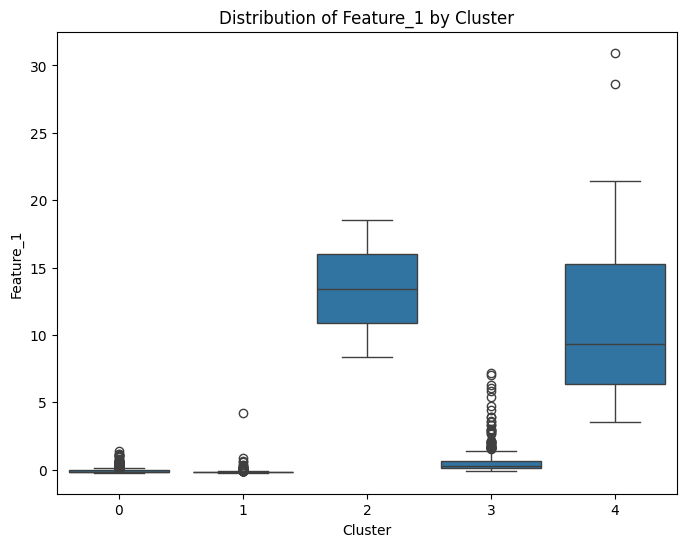

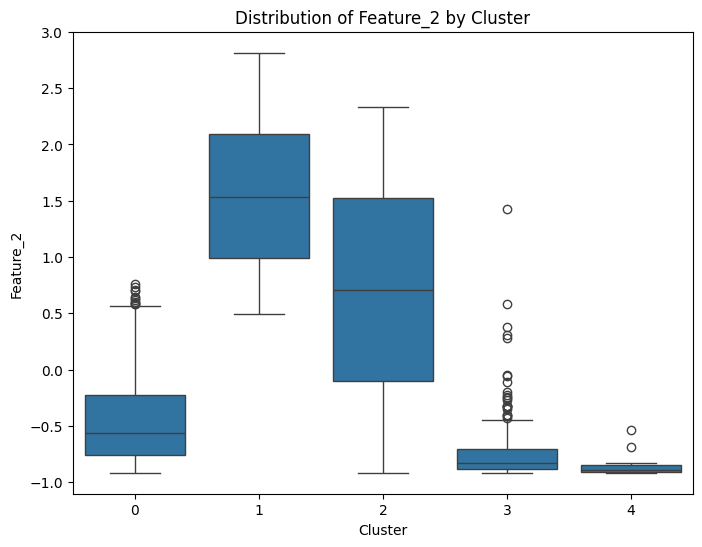

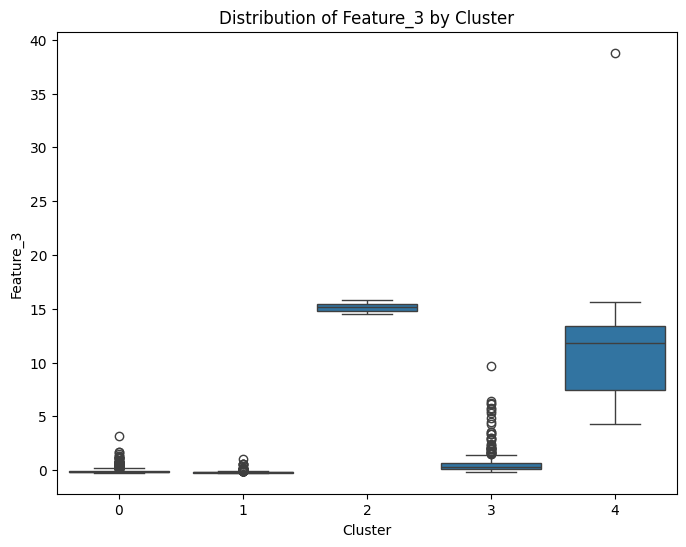

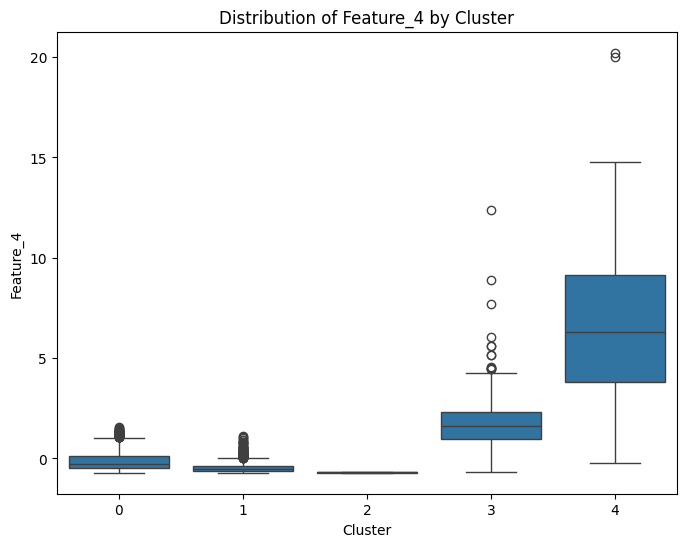

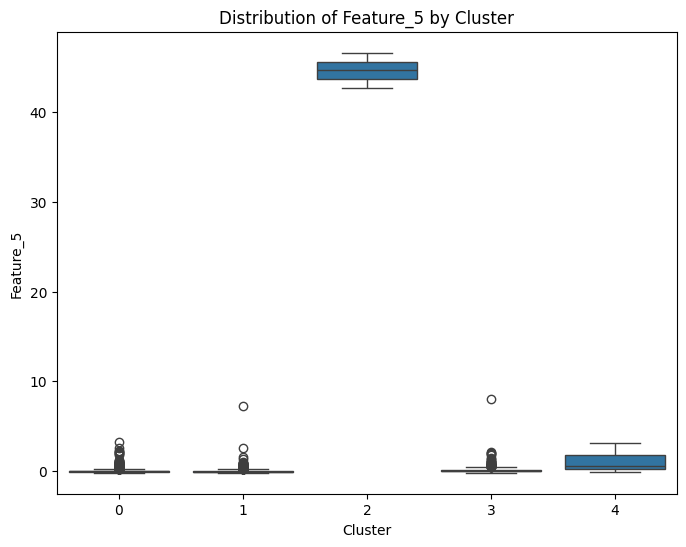

In [71]:
for feature in df_clustered.columns[:-1]:  # Exclude the 'Cluster' column
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=feature, data=df_clustered)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()



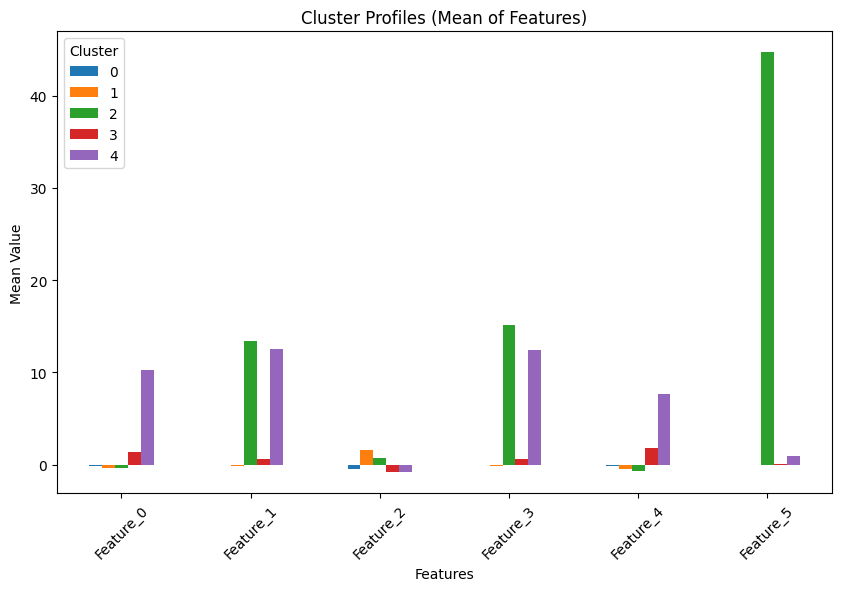

In [72]:
cluster_profiles.T.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Profiles (Mean of Features)')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.xticks(rotation=45)
plt.show()

# **PART 8**
Визуализация и интерпретация

In [77]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

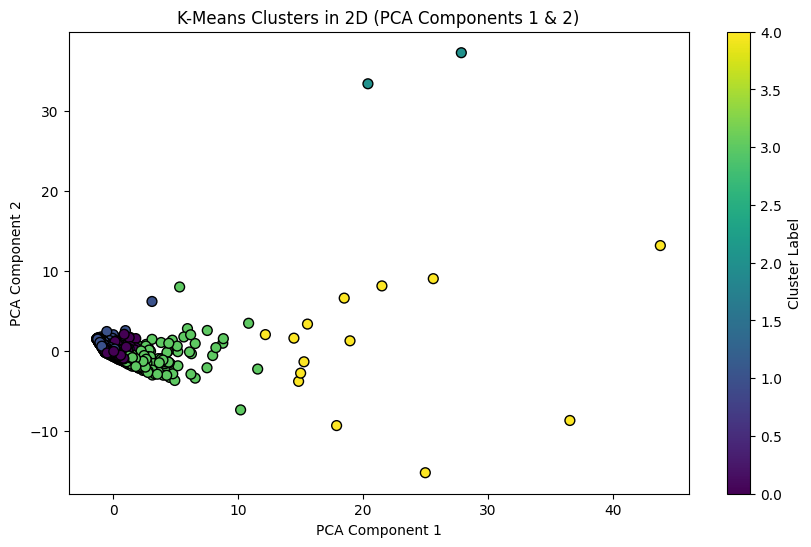

In [78]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolors='k', s=50)
plt.title('K-Means Clusters in 2D (PCA Components 1 & 2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

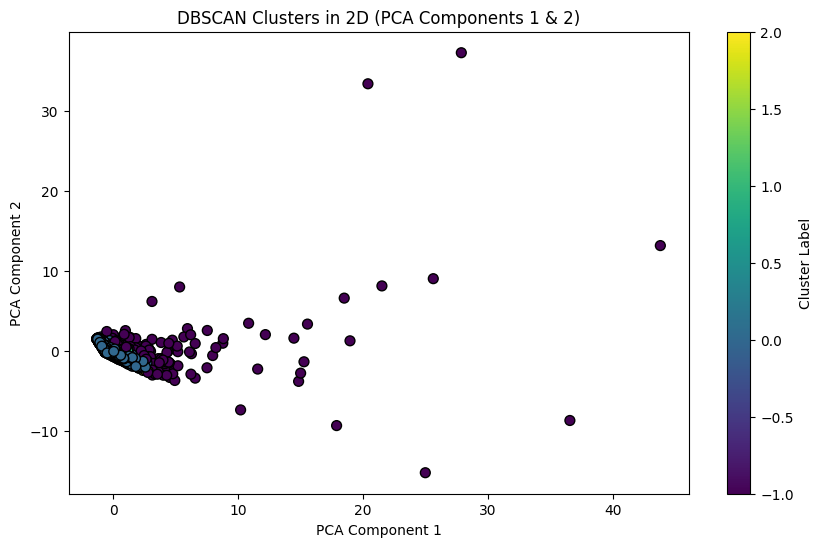

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', edgecolors='k', s=50)
plt.title('DBSCAN Clusters in 2D (PCA Components 1 & 2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [84]:
pca_full = PCA()
pca_full.fit(X_scaled)

PCA()

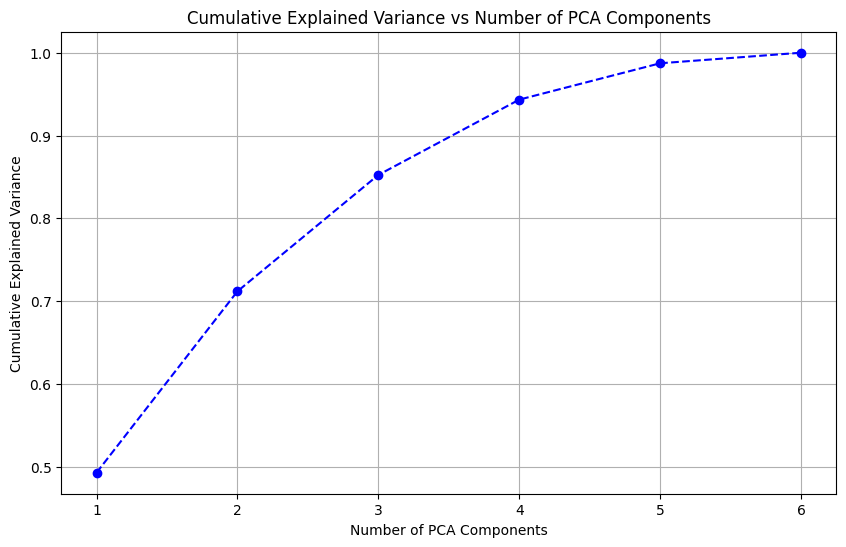

In [81]:
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance vs Number of PCA Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()